# Predicting in game win probabilities of NBA games

## Why?, How?, what else has been done?

Before I moved to Canada I never really watched basketball live, mostly due to the time difference and me liking my sleep but when I did get the oppourtunity to move here in March/April 2019 I witnessed the Toronto Raptors make their championship run and ever since then i've been hooked. 

Naturally as a Data Scientist and someone who studied Maths at university I was drawn to the numbers side of things with basketball. Advanced stats, different ways of measuring impact, elo scores and other people's efforts working with basketball data showed me the other half of the sport. 

Seeing other peoples efforts really highlighted the amount of data that can be collected and analysed so I decided to do my own project with NBA data. Python has an excellent [API wrapper](https://github.com/swar/nba_api) around stats.nba.com with access to things I didn't even know were tracked. 

An interesting part of the api is that it provided live play by play data and I became interested in how nba games were predicted live.

## Reserach / Review

Looking around at what had been done I found a few blogs/articles/papers mostly related to other sports but some around basketball (NCAA and NBA).

- [Bayesian approach to predicting football(not soccer) games](https://dtai.cs.kuleuven.be/sports/blog/a-bayesian-approach-to-in-game-win-probability) [1]

- [Brian Burkes NFL forecasting](http://wagesofwins.com/2009/03/05/modeling-win-probability-for-a-college-basketball-game-a-guest-post-from-brian-burke/) [2]

- [py-ball](https://github.com/basketballrelativity/py_ball) [3]

- [inpredictable](http://stats.inpredictable.com/nba/wpBox_live.php) [4]


Reading the [1] definitely cleared up that predicting football was a lot harder since a lot of games end in draws and there is a lot of infrequent scoring.

[2] & [3] gave me the first step in order to build a model to predict games. The approach that was used here is to split the game into n-second intervals and then build a series of logisitc regression models, one for each interval. 

[4] gave me a sense of what other blogs were doing and something to compare my graphs too

# Data Gathering

As mentioned before, python has a GREAT wrapper for the stats.nba.com api again linked [here](https://github.com/swar/nba_api), which is worth checking out in your own time just to see the volume of data available to play with. But I wrote a simple script to collect all the playbyplay data for the last ~7 odd years. 
The problem is rate limits! 

In [8]:
#script to get all live playbyplay data
from nba_api.stats.endpoints import leaguegamelog, playbyplayv2
import pandas as pd

In [2]:
seasons = [f'20{x}-{x+1}' for x in range(13,22)] #can put whatever range you want

league_game_logs = []
for season in seasons:
    game_log = leaguegamelog.LeagueGameLog(season=season).get_data_frames()[0]
    league_game_logs.append(game_log)

In [3]:
league_game_log = pd.concat(league_game_logs)

#### Filtering for home games

The reason i'm filtering for the home games below is because there can only be two outcomes in basketball, win or lose and so if you find the probability that the home team wins then you're done. The game log api wrapper returns game logs from both teams perspectives. Matchups with '@' in them are instances from the perspective of the away team.

In [4]:
league_game_log = league_game_log[~league_game_log['MATCHUP'].str.contains('@')]

once you get all the game logs you can go and retrieve all playbyplay data. Usually when there are no rate limits I spam the API (WITHIN REASON) using multiprocessing however since the NBA api has some serious API limits this is a slow burning job that'll take a few hours. I suggest you run this before you get on with something else and let it run in the background.

In [11]:
from tqdm import tqdm
from time import sleep

pbp = []
for game_id in tqdm(league_game_log.GAME_ID):
    pbp.append(playbyplayv2.PlayByPlayV2(game_id).get_data_frames()[0])
    sleep(0.2)
    #to ensure over time we aren't spamming the api and hitting any rate limits, set it to whatever.

  0%|▏                                                                                                                                                                         | 14/10284 [00:09<1:52:42,  1.52it/s]


In [13]:
df = pd.concat(pbp)
df.to_csv('bpbp.csv', index=False)

# Data Preprocessing and Featurizing 

okay we have our play by play data but now what? 
The first version of our model was to replicate what has already been done. So our current goal is to build 960 logistic regression models, one for each three second period.

Since our play by play data is not uniformly generated i.e. records have times from 0-2880 but they are not uniformly spaced and definitely not every three seconds (the shot clock itself goes on for 24 seconds) so what can we do? 

As Data Scientists real world data is never going to be perfect, formatting, quality, frequency etc but we must do what we can with what we have. 

And so we need to make assumptions and preprocess our data accordingly. 

Assumptions we're going to make:
- The state of the game is the same until the next play by play event i.e. if a play happened at 2700 and the score was 10-15 and the next play happened at 2680 and the score is now 12-15 then the time between 2700 and 2680 still has the score 10-15. 

The features we are aiming to produce are for the first iteration is

- Whos got possesion? 
- Score difference
- is it over time? 

In [ ]:
# Whos got possession? 
df[['home_true', 'visitor_true']] = df[['HOMEDESCRIPTION','VISITORDESCRIPTION']].notnull().astype(int)

df['block'] = df['HOMEDESCRIPTION'].str.contains("BLOCK").fillna(False)
df['steal'] = df['HOMEDESCRIPTION'].str.contains("STEAL").fillna(False)

def home_poss(d):
    #logic follows that whenever the home description or visitor description is filled out then its that teams 
    #possession unless theres a block or steal!
    if (d['home_true'] == 1) & (d['visitor_true']==0):
        return 1
    elif (d['home_true'] == 0) & (d['visitor_true']==1):
        return 0
    else:
        if d['block'] or d['steal']:
            return 1
        else:
            return 0
        
df['home_poss'] = df.apply(home_poss, axis = 1)

#get the score difference
df['score'] = df.groupby('GAME_ID')['SCORE'].ffill().fillna('0-0')
df[['away_score', 'home_score']] = df['score'].str.split('-', expand=True)
df['diff'] = pd.to_numeric(df['home_score']) - pd.to_numeric(df['away_score'])

#To see what period we're in, if we're in overtime it will show us what period of overtime we're in otherwise just 0
#for regulation games
df['OT_ind'] = (df['PERIOD']-4).clip(lower=0)


#to find the time remaining
from datetime import datetime

def str_to_time(str1):
    time_ = datetime.strptime(str1, "%M:%S")
    return time_.second + time_.minute*60

df['seconds'] = df['PCTIMESTRING'].apply(str_to_time)

def find_seconds_left(x):
    if x == 1:
        return 3*720
    elif x == 2: 
        return 2*720
    elif x == 3:
        return 720
    else:
        return 0
    
df['seconds_left_in_game_from_quarter'] = df['PERIOD'].apply(find_seconds_left)

df['time_remaining'] = df['seconds'] + df['seconds_left_in_game_from_quarter']

#Create our targets
df['home_team_win'] = df.groupby('GAME_ID')['diff'].last().clip(lower=0, upper=1).rename('home_team_win')

#final dataset subsetting for our relevant columns
data = df[['GAME_ID','home_poss', 'diff', 'time_remaining', 'OT_ind']]

So now we have our data in the format of 

GAME_ID | home_poss | diff | time_remaining | OT_ind | home_team_win

But, how do we build our 960 models? especially since looking at our data shows that the play by plays recorded are definitely not uniformly distributed in three second intervals

We have to do some clever indexing and fast filling

In [ ]:
game_ids = list(df['GAME_ID'].sort_values().unique())
iterables = [game_ids, list(range(2880,-1,-1))]
countdown = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=["GAME_ID", "time_remaining"])).reset_index()

final = countdown.merge(data, on = ['GAME_ID', 'time_remaining'], how='left').ffill()
final = final[final['time_remaining'].isin(range(0,2883,3))]
final.to_csv('modelling_data.csv', index=False)

Now we have our modelling data time to build our series of logisitc regression models

# Model Building - Part 1

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#create our train and test sets, our test set will be the most recent last 500 games
test_games = df['GAME_ID'].unique()[-500:]

test = df[df['GAME_ID'].isin(test_games)]
train = df[~(df['GAME_ID'].isin(test_games))]

train = train.drop('GAME_ID', axis = 1).set_index('time_remaining')
test = test.set_index(['time_remaining', 'GAME_ID'])

X = train.drop('home_team_win', axis = 1)
y = train['home_team_win']

#build our series of logistic regression models 
models = {}
for time in X.index.unique():
    model_temp = LogisticRegression()
    X_temp = X.loc[time]
    y_temp = y.loc[time]
    model_temp.fit(X_temp.values, y_temp.values)
    models[time] = model_temp

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#create our test set predictions
probs = []
preds = []
for time in test.index.levels[0]:
    temp = test.loc[time].drop('home_team_win', axis = 1)
    probs.append(pd.DataFrame(models[time].predict_proba(temp), columns = ['prob_home_lose', 'prob_home_win']))
    preds.append(pd.DataFrame(models[time].predict(temp), columns=['preds']))

probs_df = pd.concat(probs).reset_index(drop=True)
preds_df = pd.concat(preds).reset_index(drop=True)

test_df = pd.concat([test.reset_index(), probs_df, preds_df], axis = 1).set_index('GAME_ID').sort_index().sort_values(by=['OT_ind','time_remaining'], ascending=[True, False])

test_df['time'] = 2880-test_df['time_remaining']


## Moving forward!

I want to predict NBA games live, a lot of this on the fly data manipulation can make predictions slower and add a lot of over head to each computation so what can we do moving forward? 

- Include time as a feature
- How can we incorporate more team specific information


Ideas! 
- Use a neural network to learn features as we have a lot of tablular data
- Incorporate 538's ELO score - this takes into account recent team performance, injuries etc and is managed externally, completely. Obviously composing all these complicated aspects of data into one metric we lose information however it is a good heuristic for now

In [ ]:
#Get Elo Scores

def read_url_to_csv(url):
    r = requests.get(url)
    data = io.StringIO(r.text)
    df = pd.read_csv(data, sep=",")
    return df

elo_url = 'https://projects.fivethirtyeight.com/nba-model/nba_elo.csv'

elo = read_url_to_csv(elo_url)
elo = elo[elo['date'] > '2012-01-01']

elo.loc[:, 'elo_difference'] = np.abs(elo['elo1_pre'] - elo['elo2_pre'])

elo = elo[['date', 'team1', 'elo1_pre', 'elo2_pre', 'elo_difference']]

elo['team1'] = elo['team1'].replace({'BRK':'BKN',
                                     'PHO':'PHX',
                                    'CHO':'CHA',})

#To merge ELO scores with my games since game_id isn't a universal key amongst disparate basketball data sources

all_games = league_game_log.copy()
all_games[['Home', 'Away']] = all_games['MATCHUP'].str.split('vs.', expand=True)
all_games['Home'] = all_games['Home'].str.strip()
all_games['GAME_ID'] = all_games['GAME_ID'].astype(int)
all_games['home_team_win'] = all_games['WL'].replace({'W':1, 'L':0})


elo_w_game_ids = all_games.merge(elo, left_on=['GAME_DATE', 'Home'], right_on = ['date', 'team1'])
#merge it with our 'not standardized' to three seconds data
df = df.merge(elo_w_game_ids[['GAME_ID', 'elo1_pre', 'elo2_pre', 'elo_difference', 'home_team_win']], on = ['GAME_ID'])

In [ ]:
train_games = games[:7000]
test_games = games[7000:]
train = df[df['GAME_ID'].isin(train_games)].drop(['GAME_ID', 'elo_difference'], axis = 1)

X_train = train.drop(['home_team_win'], axis = 1)
y_train = train['home_team_win']


test = df[df['GAME_ID'].isin(test_games)]

X_test = test.drop(['home_team_win', 'GAME_ID'], axis = 1)
y_test = test['home_team_win']

In [2]:
import tensorflow as tf

In [3]:
model_wO_elo = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, activation='relu', input_shape=[4,]),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_wO_elo.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model_wO_elo.summary()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, activation='relu', input_shape=[6,]),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                60        
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                84        
                                                                 
 dense_4 (Dense)             (None, 

2022-02-03 08:05:46.740678: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
X_train_wO_elo = X_train.drop(['elo1_pre', 'elo2_pre'], axis = 1)

In [ ]:
model_wO_elo.fit(X_train_wO_elo.values,
          y_train.values,
          verbose=1,
          shuffle=True,
          epochs=15,
          batch_size=512)

model.fit(X_train.values,
          y_train.values,
          verbose=1,
          shuffle=True,
          epochs=15,
          batch_size=512)

model.save('../Models/TF_model_w_elo.h5')
model_wO_elo.save('../Models/TF_model_wO_elo.h5')

In [ ]:
test.loc[:, 'preds_w_elo'] = model.predict_on_batch(X_test[X_train.columns])

test.loc[:, 'preds_wO_elo'] = model_wO_elo.predict_on_batch(X_test[X_train_wO_elo.columns])

# Evaluating our model



## Brier Score

### What is it? 
#### Brier Score Loss = $\frac{1}{N}\sum_{i=1}^{N}(p_{i} - y_{i})^2$

where:
- $p_{i}$ is the predicted probability of the sample
- $y_{i}$ is the true value (either 1 or 0)
- N is the number of samples

A way to interpret this metric is as a less harsh version of log loss


## Log Loss

### What is it?

Log loss is the $-1$*(average of the log of the corrected probabilities)

### so what does that mean? 

An example for corrected probabilities
- True = [1,0,1]
- predicted = [0.9, 0.3, 0.1] 
- corrected_probabilities = [0.9, 0.3, 0.9]
- log of the corrected probabilities = [-0.10536052, -1.2039728 , -0.10536052]
- sum of above = -1.4146938356415888
- average of sum = -0.47
- -1 * avg of sum = 0.47

### As a formula 

#### Log Loss  = -$\frac{1}{N}\sum_{i=1}^{N}y_{i}(log(p_{i})) + (1-y_{i})log(1-p_{i})$


### Why does this exist?

You can use just the liklihoods and just multiply the corrected probabilities to get a model score BUT, as N gets large the model score gets very small and so thats why we use logs, we use -1 to keep the convention of "the lower the score the better"


### What does less harsh mean? 

Something I asked too but an easy way to see that is by plotting the log graph vs the x^2 graph

/var/folders/6n/_mn7r8yx4fd_kqsrk0pcy6hc0000gn/T/ipykernel_5981/2558506998.py:10: RuntimeWarning: divide by zero encountered in log
  log_y = [-np.log(x_) for x_ in x]


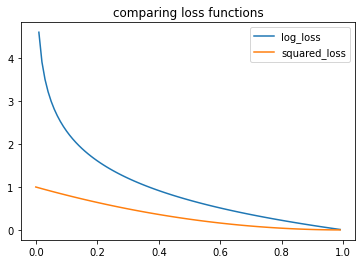

In [6]:
# Plot the graphs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig, ax = plt.subplots()

x = np.arange(0,1,0.01)
y = [(1-x_)**2 for x_ in x]
log_y = [-np.log(x_) for x_ in x]
ax.plot(x,log_y, label = 'log_loss')
ax.plot(x, y, label = 'squared_loss')
ax.set_title('comparing loss functions')
ax.legend()

## The grand reveal

Our brier scores for our two models are

In [8]:
from sklearn.metrics import brier_score_loss
print('Brier Score for model built with elo:')
brier_score_loss(test['home_team_win'], test['preds_w_elo'])

Brier Score for model built with elo:
0.15495321224308004


In [9]:
print('Brier Score for model built without elo:')
brier_score_loss(test['home_team_win'], test['preds_wO_elo'])

Brier Score for model built without elo:
0.1654293641223685


## Which is pretty good! 

I'll be writing about how I deployed this model with fast api, docker etc on another post

###### These articles are subject to revision because learning is a journey 